# Estimating Mean/Variance of a Population

We would like to infer the measures of centrality and spread of a population based on a representative/random sample

![estimation_point.png](images/estimation_point.png)

## Data preparation

Let's simulate a population and see how we can estimate its mean/variance through a random sample

We'll simulate a population of 100,000 residents with their height (cm) measurements

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



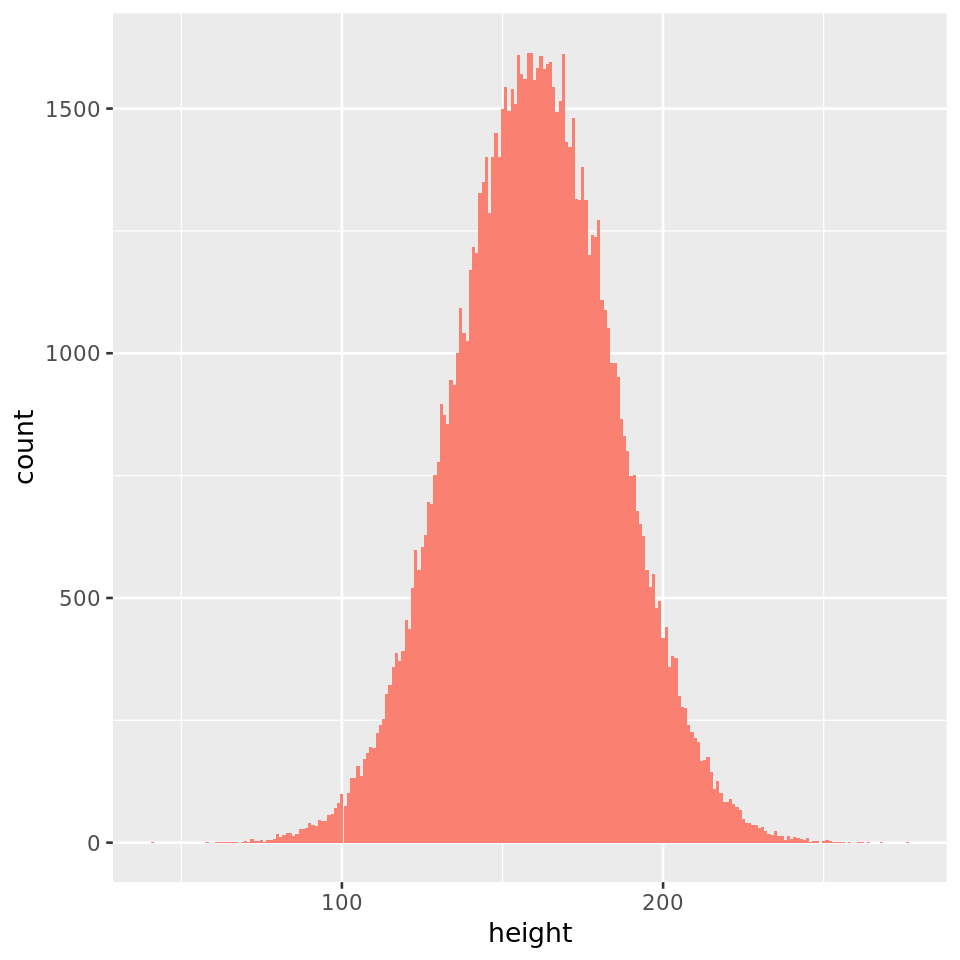

In [ ]:
library(tidyverse)

# Imagine a town with 100,000 residents and measure everyone's height (cm)
population <- rnorm(100000,160,25)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

population %>% 
tibble(height=.) %>% 
ggplot(aes(x=height)) + 
  geom_histogram(fill="salmon", binwidth=1) +
  theme_grey(base_size=16)

Here, we can calculate the population mean and variance that we will try and estimate through sampling

$$
\mu=\frac{\sum{x}}{n}
$$


$$
\mathit{var}=\frac{\sum(x-\bar{x})^{2}}{n}
$$

In [ ]:
variance <- function(data) {
    
    input_mean <- mean(data)
    sum_squares <- sum((data-input_mean)^2)
    num_input <- length(data)
    variance <- sum_squares/num_input
    
    return(variance)
    
}

population_mean <- mean(population)
population_var <- variance(population)

tibble(stat=c("Population mean","Population variance"),
       value=c(population_mean, population_var))

stat,value
<chr>,<dbl>
Population mean,159.9228
Population variance,622.2319


## What are the estimates of mean and variance in one sample?

Let's try and take one sample (n=10) and calculate the mean and variance of the sample and see if it resembles the population parameters

In [ ]:
# sample once and report the mean and variance
# you can rerun this cell to see how it changes with each sample
sample_data <- sample(population, size=10, replace=F)

sample_mean <- mean(sample_data)
sample_var <- variance(sample_data)

tibble(stat=c("Population mean","Population variance",
              "Sample mean","Sample variance"),
       value=c(population_mean, population_var, 
               sample_mean,sample_var))

stat,value
<chr>,<dbl>
Population mean,159.9228
Population variance,622.2319
Sample mean,164.0804
Sample variance,342.2688


## How are the sample estimates over a long run?

Let us repeat the samples multiple times to see how these sample estimates change over the long run. We can also determine the average of these sample estimates and to see if they approximate the population estimates

We define a function `sample_multiple` that repeats the sampling and calculates the sample mean and variance for each replicate

```
sample_multiple(num_replicate = number of replicates,
                num_sample = sample size per replicate
                pop = population)
```

In [ ]:
# function to generate replicates by calling sample_once function
sample_multiple <- function(num_replicate, num_sample, pop) {
    
    replicate(num_replicate, 
              tibble(value=sample(pop, num_sample, replace=F)), 
              simplify = FALSE) %>%
    bind_rows %>% 
    mutate(replicate=rep(1:num_replicate, each=num_sample), n=num_sample) %>% # add replicate and sample numbers
    return
    
}

In [ ]:
# for reproducibility
set.seed(101)

# sample 10 at a time, and repeat 1000 times for each sample
sample_1000 <- sample_multiple(num_replicate=1000,
                               num_sample=10,
                               pop=population)

head(sample_1000)
tail(sample_1000)

value,replicate,n
<dbl>,<int>,<dbl>
141.71346,1,10
103.32544,1,10
173.17304,1,10
97.96835,1,10
150.16176,1,10
147.55589,1,10


value,replicate,n
<dbl>,<int>,<dbl>
176.4706,1000,10
116.2507,1000,10
141.1083,1000,10
161.2064,1000,10
106.4631,1000,10
170.9804,1000,10


We will visualize the distribution of the sample mean and variance estimates over 1000 replicates. We will then calculate the average of these sample estimates and compare them to the population estimates
- `red` line indicates the population estimate
- `blue` line indicates the average of the sample estimate over 1000 replicates

In [ ]:
estimate_mean_var <- sample_1000 %>% 
                     group_by(replicate) %>%
                     summarize(mean = mean(value), 
                               var = variance(value))

# find average estimates of mean and variance over multiple runs
estimate_mean <- estimate_mean_var %>% 
                 pull(mean) %>% 
                 mean
estimate_var <- estimate_mean_var %>% 
                pull(var) %>% 
                mean

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



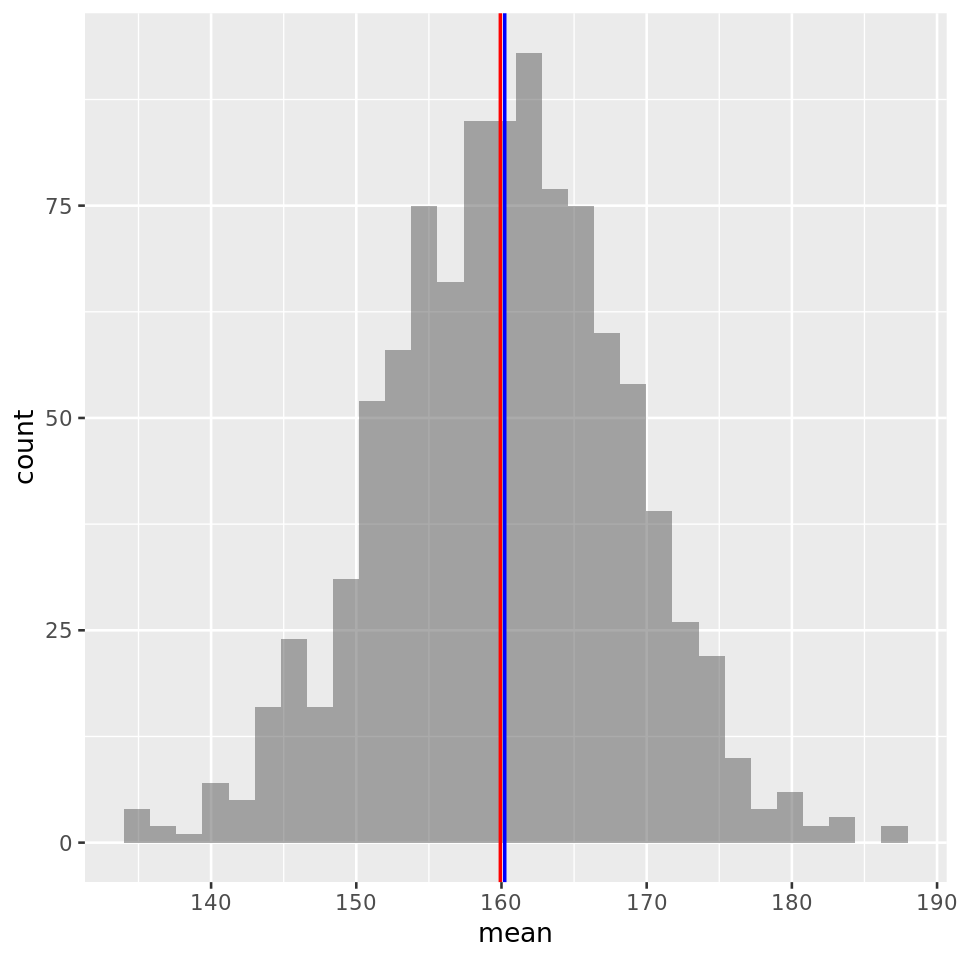

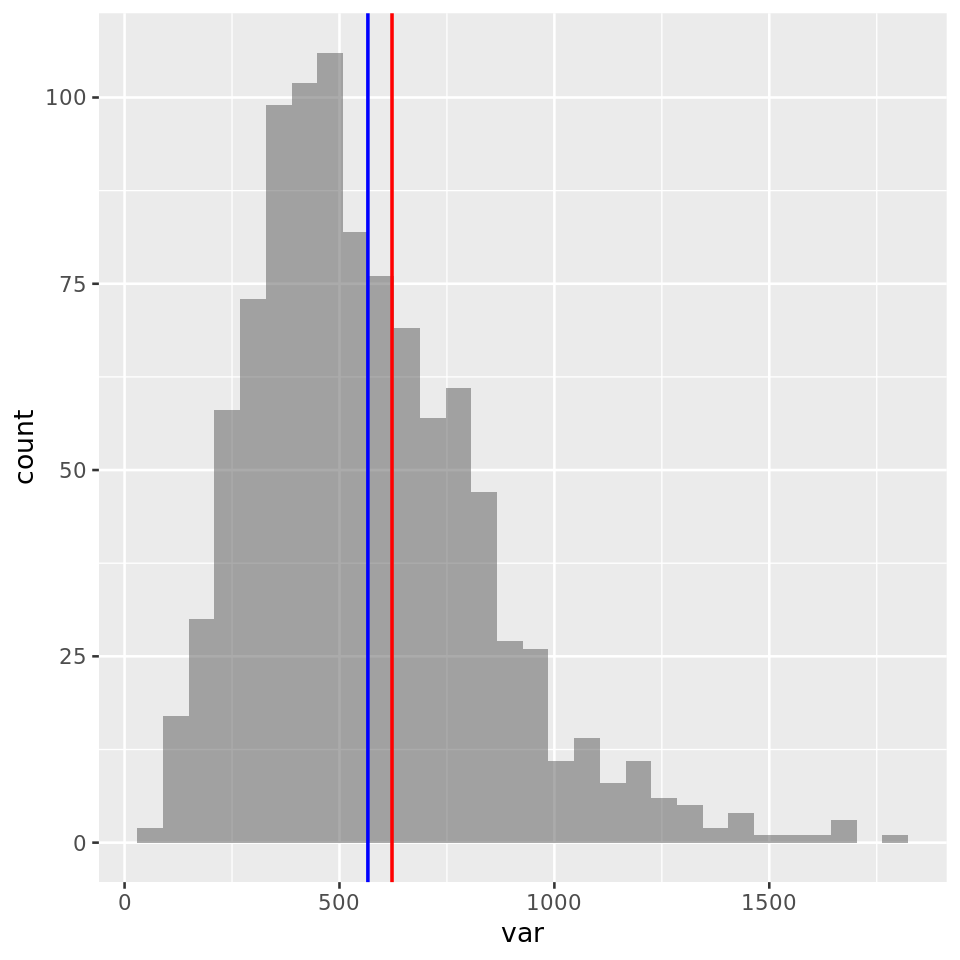

In [ ]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

estimate_mean_var %>% 
ggplot(aes(x=mean)) + 
  geom_histogram(alpha=0.5) +
  geom_vline(xintercept = population_mean, color="red", size=1) +
  geom_vline(xintercept = estimate_mean, color="blue", size=1) +
  theme_grey(base_size=16)

estimate_mean_var %>% 
ggplot(aes(x=var)) + 
  geom_histogram(alpha=0.5) +
  geom_vline(xintercept = population_var, color="red", size=1) +
  geom_vline(xintercept = estimate_var, color="blue", size=1) +
  theme_grey(base_size=16)

In [ ]:
tibble(stat=c("Population mean","Population variance",
              "Sample mean","Sample variance"),
       value=c(population_mean, population_var, 
               estimate_mean,estimate_var))

stat,value
<chr>,<dbl>
Population mean,159.9228
Population variance,622.2319
Sample mean,160.2225
Sample variance,566.1102


It appears that in multiple samples over a long run:
- The sample mean is a good estimate of the population mean
- The sample variance is _underestimating_ the population variance

To address the underestimation of the population variance, we will define another function ```variance_unbiased``` that includes a correction factor

$$
\mathit{var}=\frac{\sum(x-\bar{x})^{2}}{n-1}
$$


- Instead of dividing the sum of squares by the number of samples, we divide it by the `number of samples minus 1`

In [ ]:
variance_unbiased <- function(data) {
    
    input_mean <- mean(data)
    sum_squares <- sum((data-input_mean)^2)
    num_input <- length(data) - 1          # correction factor
    variance_unbiased <- sum_squares/num_input
    
    return(variance_unbiased)
}

We will take 1000 replicates of samples (n=10) from the population and find the average of the sample mean and unbiased variance estimators

In [ ]:
estimate_mean_var_unbiased <- sample_1000 %>% 
                              group_by(replicate) %>%
                              summarize(mean=mean(value), 
                                        var=variance_unbiased(value))

estimate_var_unbiased <- estimate_mean_var_unbiased %>% 
                         pull(var) %>% 
                         mean

We can plot the distribution and compare the average of the sample estimates with the population estimates
- `red` line indicates the population estimate
- `blue` line indicates the average of sample estimate over 1000 replicates

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



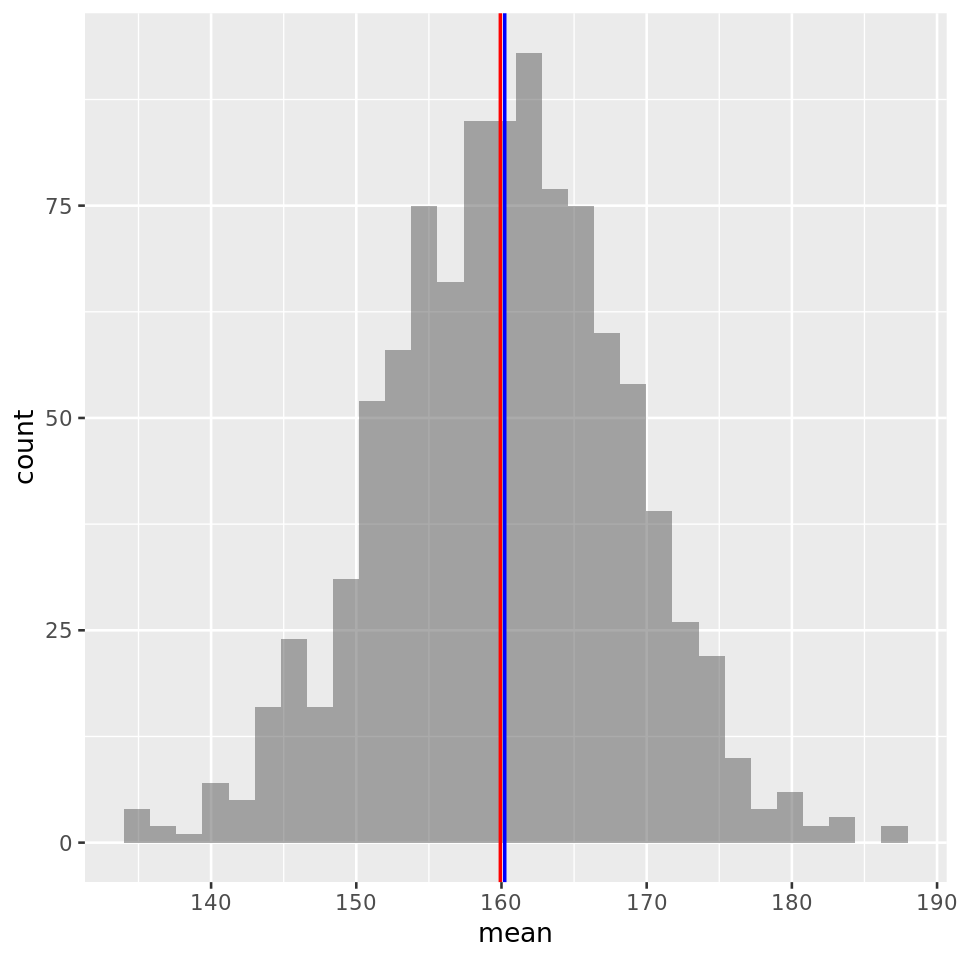

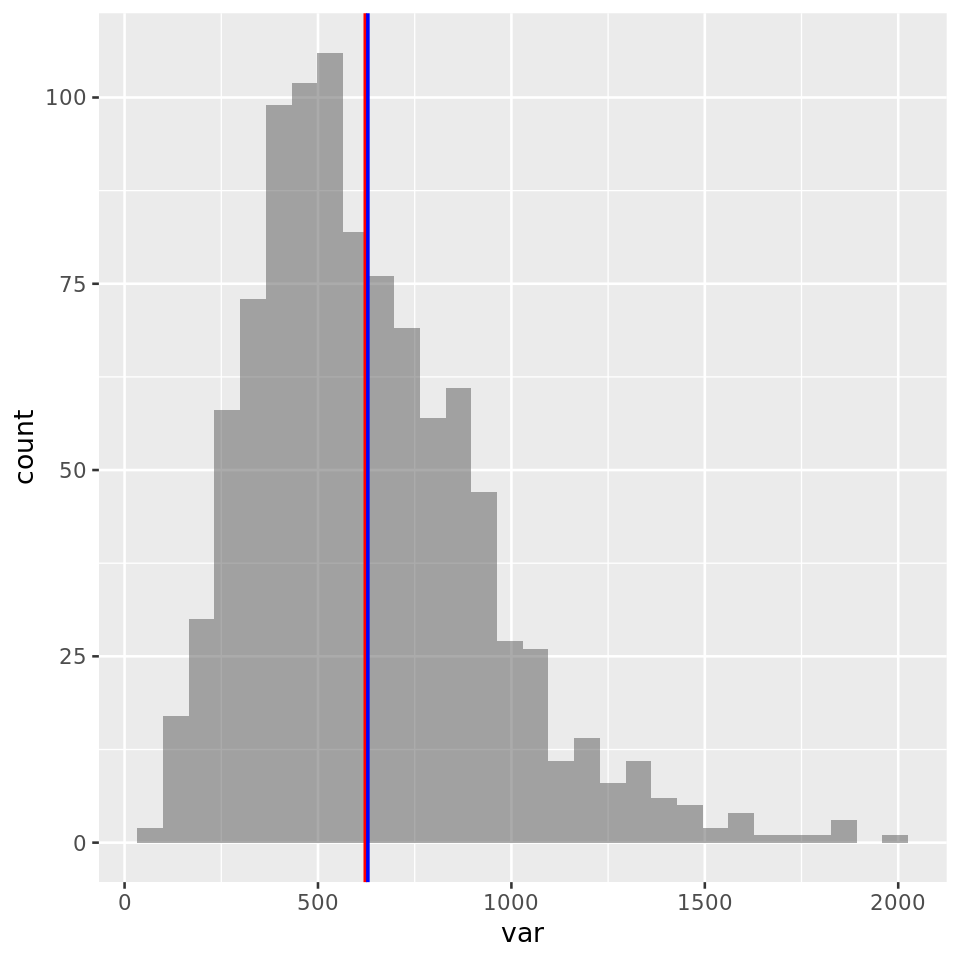

In [ ]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

estimate_mean_var_unbiased %>% 
ggplot(aes(x=mean)) + 
  geom_histogram(alpha=0.5) +
  geom_vline(xintercept = population_mean, color="red", size=1) +
  geom_vline(xintercept = estimate_mean, color="blue", size=1) +
  theme_grey(base_size=16)

estimate_mean_var_unbiased %>% 
ggplot(aes(x=var)) + 
  geom_histogram(alpha=0.5) +
  geom_vline(xintercept = population_var, color="red", size=1) +
  geom_vline(xintercept = estimate_var_unbiased, color="blue", size=1) +
  theme_grey(base_size=16)

In [ ]:
tibble(stat=c("Population mean","Population variance",
              "Sample mean","Sample variance",
              "Sample variance (unbiased)"),
       value=c(population_mean, population_var, 
               estimate_mean,estimate_var, estimate_var_unbiased))

stat,value
<chr>,<dbl>
Population mean,159.9228
Population variance,622.2319
Sample mean,160.2225
Sample variance,566.1102
Sample variance (unbiased),629.0114


We see that the unbiased estimate of the variance with the correction factor is closer to the true population variance

## Why is n-1 used as a correction in the sample variance estimation?
- Intuitively:

![sample_var.png](images/sample_var.png)

- for a technical explanation see: http://mathcenter.oxford.emory.edu/site/math117/besselCorrection/


## Why are unbiased sample estimators important?
- The unbiased sample estimates of the mean and variance can be used as parameters to calculate the distribution of the population analytically using a theoretical distribution
- In other words, the sample can be used to infer the population, provided we have an idea of the underlying distribution

Let's take a sample of 100 people and calculate the sample mean and variance

In [ ]:
num_samples <- 100

# sample without replacement
sample_fraction <- sample(population, size=num_samples, replace=F)

# calculate sample mean and variance (unbiased)
sample_mean <- mean(sample_fraction)
sample_var <- sum((sample_fraction - sample_mean)^2)/(num_samples-1) # correction

tibble(stat=c("Sample mean","Sample variance"),
       value=c(sample_mean, sample_var))

stat,value
<chr>,<dbl>
Sample mean,159.2264
Sample variance,605.9751


We can now use these sample estimates to recreate the population using a theoretical distribution 
- a normal distribution of heights is assumed
- the shape of a normal distribution is determined by 2 parameters, the mean and the standard deviation (the square root of the variance)

We generate values of heights from a theoretical normal distribution using the `rnorm` function

```
rnorm(number of values, mean, standard deviation)
```



In [ ]:
population_values <- tibble(type = "population", 
                            height = population)

sample_values <- tibble(type = "theoretical", 
                        height = rnorm(100000, 
                                      sample_mean, 
                                      sqrt(sample_var)))

compare_dist <- bind_rows(population_values, 
                          sample_values)

head(compare_dist)
tail(compare_dist)

type,height
<chr>,<dbl>
population,137.6731
population,165.8582
population,95.4576
population,151.9225
population,190.6606
population,156.6854


type,height
<chr>,<dbl>
theoretical,158.5571
theoretical,157.1428
theoretical,173.7631
theoretical,194.1477
theoretical,202.3675
theoretical,162.6785


We can see how the theoretical distribution of heights (based on the sample mean/variance) compares to the actual population

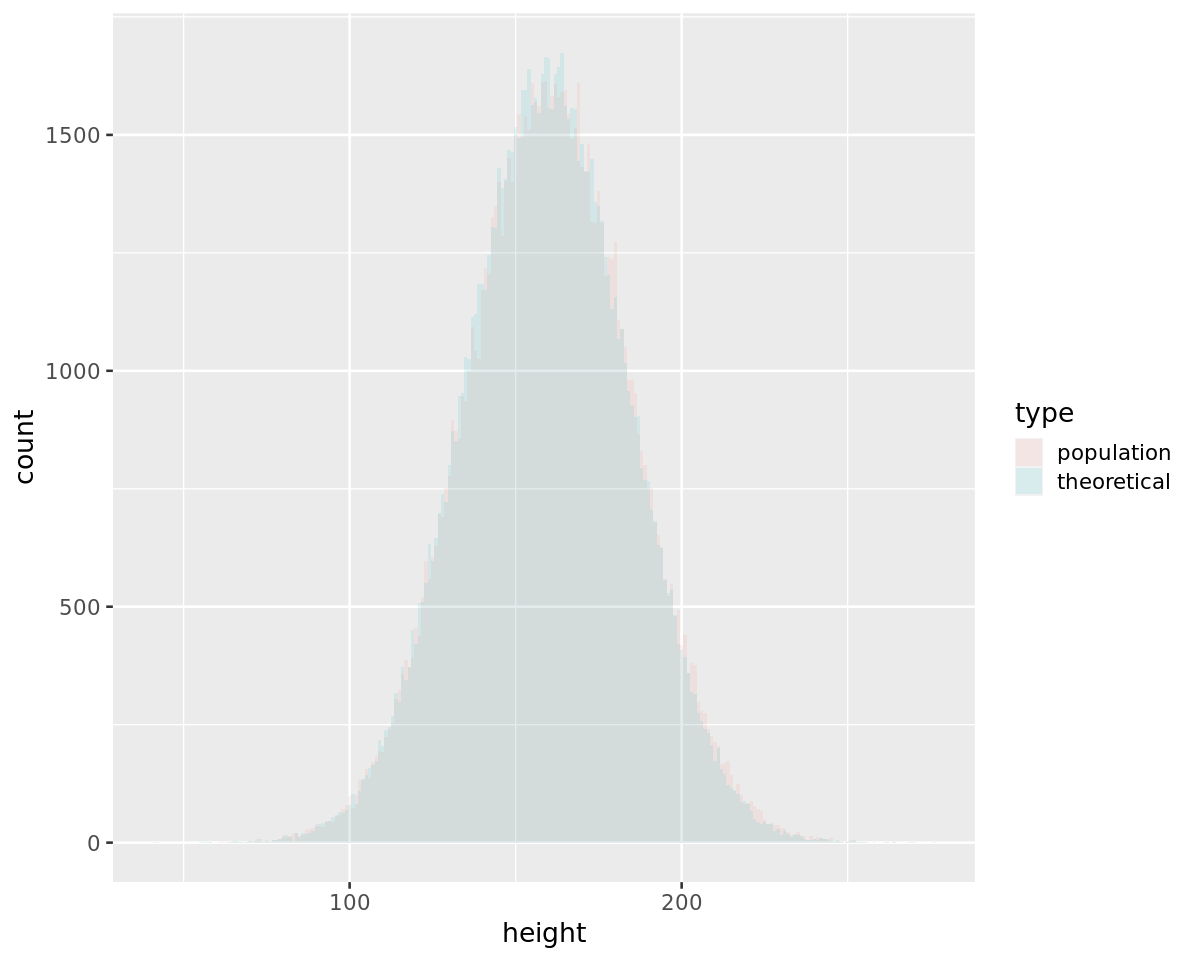

In [ ]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=8)

compare_dist %>% 
ggplot(aes(x=height, fill=type)) + 
  geom_histogram(position="identity", binwidth=1, alpha=0.1) + 
  theme_grey(base_size=16) 

The distributions look pretty similar, which means that we can infer the characteristics of the population based on the sample estimates and underlying theoretical distribution

## Does the sample size (n) matter?

It appears that we can get a pretty good approximation of the population characteristics based on a sample of 100. 

Let's see how taking different sample sizes (10, 100, 1000) affects our ability to infer the mean of the population. We will generate 1000 replicates of samples for each of the sample sizes

In [ ]:
# sample 10, 100, 1000 people
sample_n_10 <- sample_multiple(1000,10,population)
sample_n_100 <- sample_multiple(1000,100,population)
sample_n_1000 <- sample_multiple(1000,1000,population)

compare_sample_n <- bind_rows(sample_n_10, 
                              sample_n_100, 
                              sample_n_1000) %>%
                    mutate(n=as.factor(n))

head(compare_sample_n %>% filter(n==10))
head(compare_sample_n %>% filter(n==100))
head(compare_sample_n %>% filter(n==1000))

value,replicate,n
<dbl>,<int>,<fct>
166.9609,1,10
159.8656,1,10
180.4839,1,10
117.8701,1,10
143.2552,1,10
192.5538,1,10


value,replicate,n
<dbl>,<int>,<fct>
158.6212,1,100
171.8050,1,100
124.4861,1,100
132.5249,1,100
133.4938,1,100
166.6239,1,100


value,replicate,n
<dbl>,<int>,<fct>
147.9273,1,1000
144.3842,1,1000
153.7885,1,1000
178.7998,1,1000
172.6537,1,1000
162.9285,1,1000


We calculate the sample mean for each replicate with the different sample sizes (10, 100, 1000)

In [ ]:
compare_sample_n_data <- compare_sample_n %>% 
                         group_by(n, replicate) %>%
                         summarize(mean=mean(value))

head(compare_sample_n_data %>% filter(n==10))
head(compare_sample_n_data %>% filter(n==100))
head(compare_sample_n_data %>% filter(n==1000))

`summarise()` has grouped output by 'n'. You can override using the `.groups`
argument.


n,replicate,mean
<fct>,<int>,<dbl>
10,1,172.9598
10,2,153.6261
10,3,173.8171
10,4,148.6974
10,5,157.2204
10,6,154.0154


n,replicate,mean
<fct>,<int>,<dbl>
100,1,159.0004
100,2,159.4585
100,3,161.8942
100,4,157.3788
100,5,158.2939
100,6,159.1738


n,replicate,mean
<fct>,<int>,<dbl>
1000,1,161.3278
1000,2,160.3521
1000,3,159.6380
1000,4,159.4898
1000,5,159.4387
1000,6,159.6882


We can plot the distribution of the sample means (1000 replicates) for the different sample sizes (10, 100, 1000)

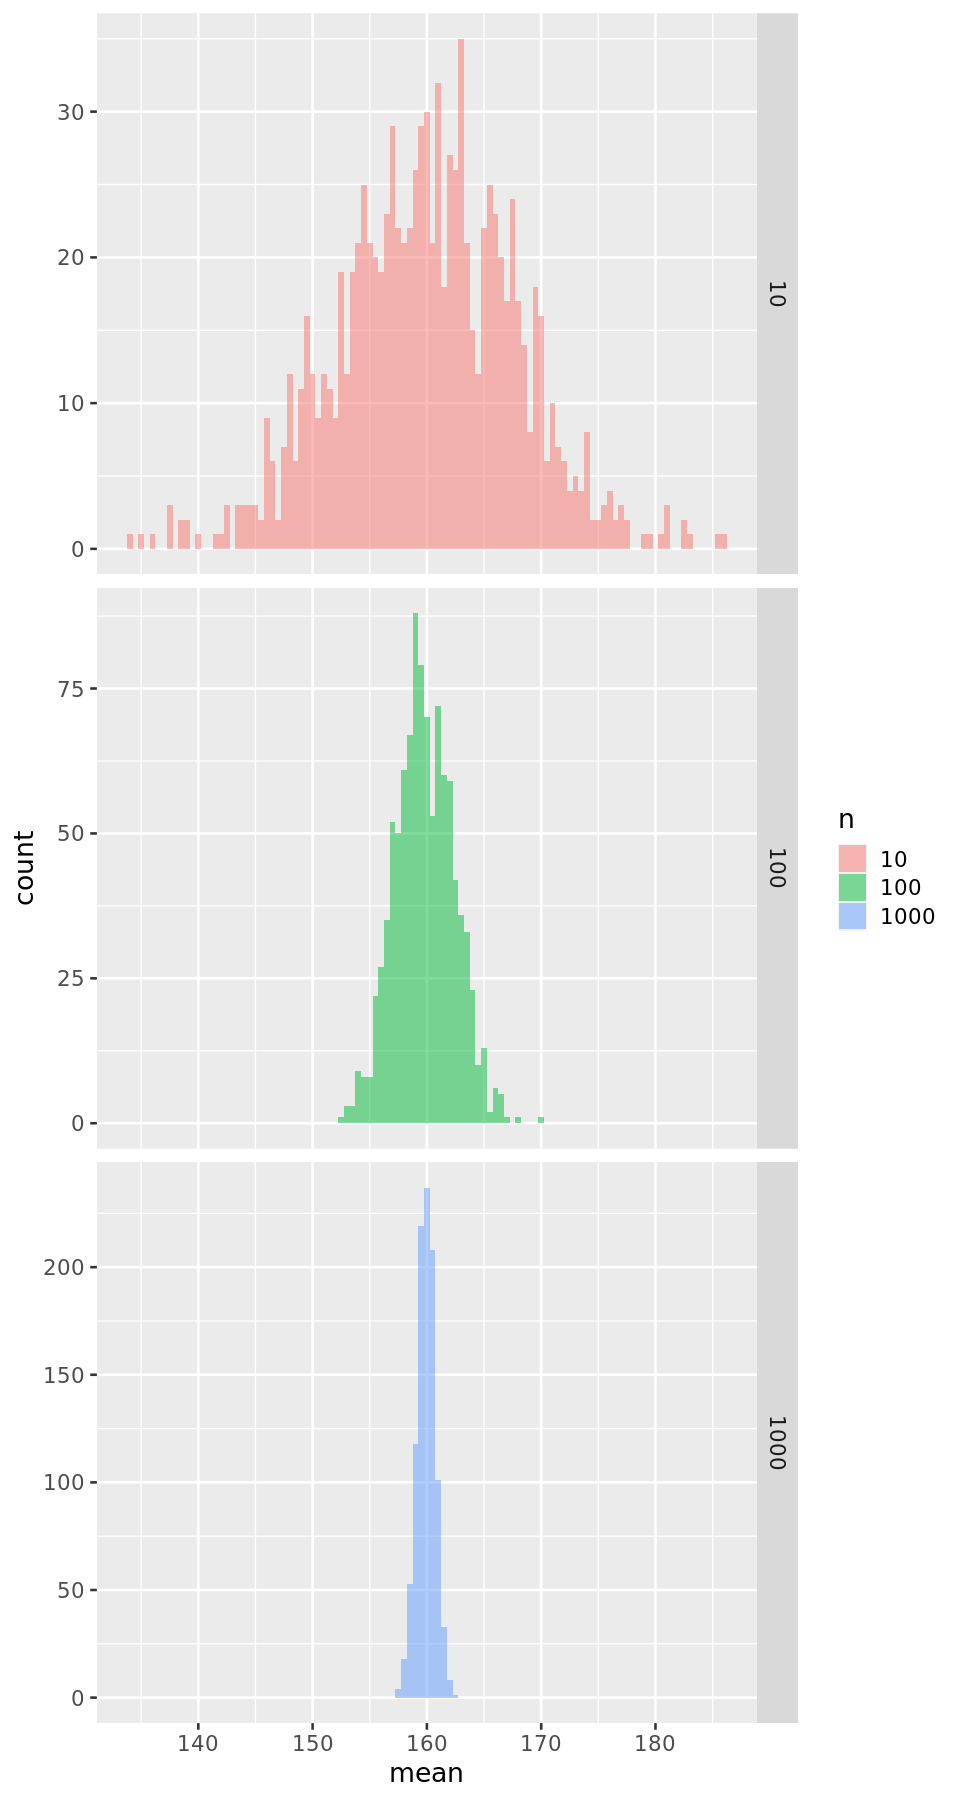

In [ ]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=15)

# split plots by the number of samples
compare_sample_n_data %>% 
ggplot(aes(x=mean, fill=n)) + 
  geom_histogram(binwidth=0.5, alpha=0.5) +
  facet_grid(n ~ ., scales="free_y") +
  theme_grey(base_size=16)

We can see that the estimated population mean based on the sample varies depending on the sample size. The larger the sample size, the smaller the variation in the estimate of the mean

In [ ]:
compare_sample_n_data %>% 
group_by(n) %>%
summarize(sd_means = sd(mean))

n,sd_means
<fct>,<dbl>
10,7.7984317
100,2.5902336
1000,0.7948246


The variation (standard deviation) in the sample means is known as the standard error of means (SEM)

### Standard error of means (SEM)

Instead of doing resampling, the standard error of means can be approximated analytically by dividing the standard deviation of measurements in **one sample** by the square root of the number of measurements

$$SE=\frac{\sigma}{\sqrt{n}}$$

To illustrate this, let us take one random sample of 100 from the population

In [ ]:
# Take 1 random sample
sample <- sample(population, size=100, replace=F)

head(sample)

[1] 134.9713 162.5671 142.6767 148.5474 147.5562 167.9971

We can obtain the standard error by calculating the standard deviation from this one sample and dividing it by the square root of the number of measurements  (n=100)

In [ ]:
# calculate the standard deviation of 1 sample
sample_sd <- sd(sample)

# calculate the standard error of means
sample_sem <- sd(sample)/sqrt(100)

tibble(stat=c("Standard deviation", "Standard error of means"),
       value=c(sample_sd, sample_sem))

stat,value
<chr>,<dbl>
Standard deviation,26.999079
Standard error of means,2.699908


We can see that the standard error of means from the calculation is close to the value we obtained through repeated sampling

Note that the standard deviation and standard error have different meanings
- The standard deviation describes the variation of values around the mean in **1 sample**
- The SEM shows the variation of means estimated from **multiple samples** (i.e. how closely the sample mean represents the population mean)

Here is a great explanation: https://youtu.be/A82brFpdr9g

## Does the population distribution matter when estimating the mean from a sample?

It would appear that the estimation of the population mean from samples is restricted to a normal distribution. Surprisingly, it does not

We can simulate a non-normal distribution of heights and see if we can estimate the population mean

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



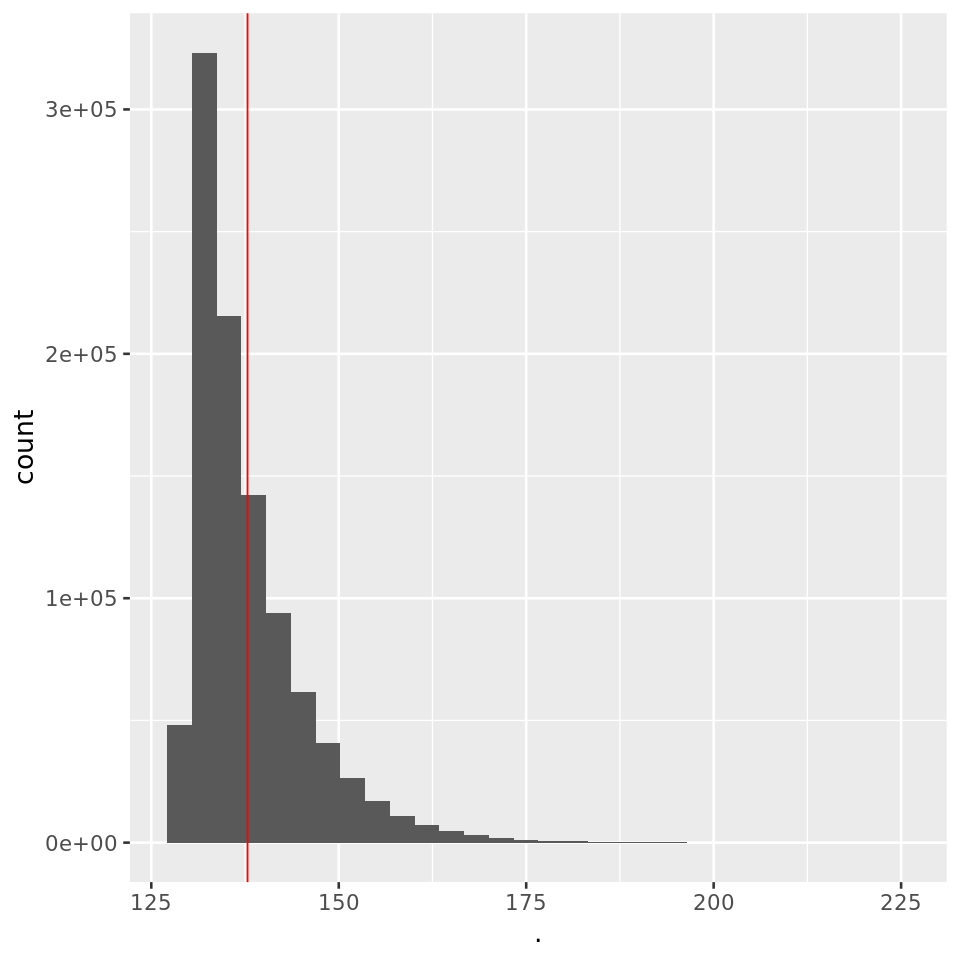

In [ ]:
# generate non-normal population
population_not_normal <- rbeta(1000000, 1,50)*400+130 # beta distribution

population_not_normal_mean <- mean(population_not_normal)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

population_not_normal %>% 
tibble %>% # convert to tibble for ggplot
ggplot(aes(.)) + 
  geom_histogram() +
  geom_vline(xintercept = population_not_normal_mean, color="red") +
  theme_grey(base_size=16)

In [ ]:
tibble(stat=c("Population mean"),
       value=c(population_not_normal_mean))

stat,value
<chr>,<dbl>
Population mean,137.8368


As before, we will generate 1000 replicates of samples for each of the sample sizes (10, 100, 1000)

In [ ]:
sample_n_10 <- sample_multiple(1000,10,population_not_normal)
sample_n_100 <- sample_multiple(1000,100,population_not_normal)
sample_n_1000 <- sample_multiple(1000,1000,population_not_normal)

compare_sample_n <- bind_rows(sample_n_10, 
                              sample_n_100, 
                              sample_n_1000) %>%
                    mutate(n=as.factor(n))
head(compare_sample_n %>% filter(n==10))
head(compare_sample_n %>% filter(n==100))
head(compare_sample_n %>% filter(n==1000))

value,replicate,n
<dbl>,<int>,<fct>
146.3613,1,10
145.2027,1,10
134.2406,1,10
132.0991,1,10
136.9949,1,10
135.4612,1,10


value,replicate,n
<dbl>,<int>,<fct>
145.8748,1,100
136.1459,1,100
133.3942,1,100
139.3956,1,100
134.1010,1,100
148.7314,1,100


value,replicate,n
<dbl>,<int>,<fct>
130.9633,1,1000
130.6383,1,1000
141.6055,1,1000
133.4666,1,1000
143.8055,1,1000
136.6778,1,1000


We calculate the sample mean for each replicate with the different sample sizes (10, 100, 1000)

In [ ]:
compare_sample_n_data <- compare_sample_n %>% 
                         group_by(n, replicate) %>%
                         summarize(mean=mean(value))

head(compare_sample_n_data %>% filter(n==10))
head(compare_sample_n_data %>% filter(n==100))
head(compare_sample_n_data %>% filter(n==1000))

`summarise()` has grouped output by 'n'. You can override using the `.groups`
argument.


n,replicate,mean
<fct>,<int>,<dbl>
10,1,139.3060
10,2,139.0266
10,3,135.6733
10,4,137.7051
10,5,135.5555
10,6,135.8469


n,replicate,mean
<fct>,<int>,<dbl>
100,1,138.9436
100,2,138.4223
100,3,137.8537
100,4,138.8154
100,5,138.7840
100,6,137.5769


n,replicate,mean
<fct>,<int>,<dbl>
1000,1,138.2920
1000,2,137.8108
1000,3,137.8769
1000,4,138.0471
1000,5,137.9884
1000,6,137.5843


We can plot the distribution of the sample means (1000 replicates) for the different sample sizes (10, 100, 1000)

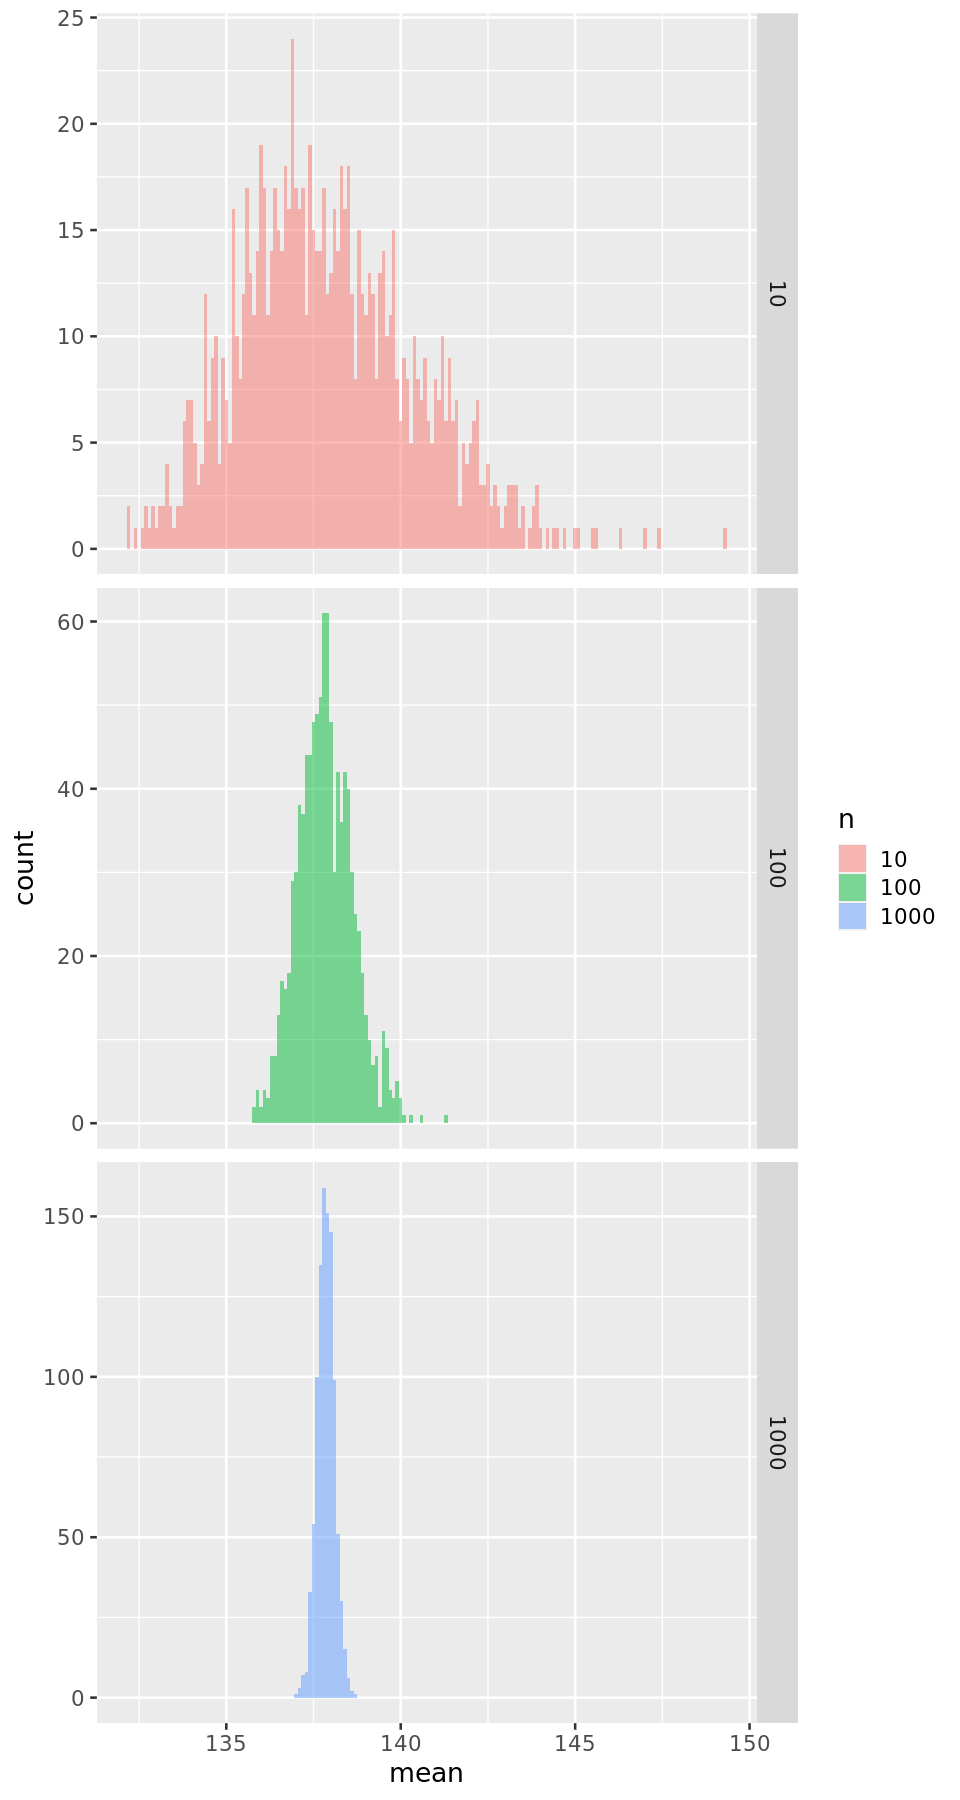

In [ ]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=15)

# split plots

compare_sample_n_data %>% 
ggplot(aes(x=mean, fill=n)) + 
  geom_histogram(binwidth=0.1, alpha=0.5) +
  facet_grid(n ~ ., scales="free_y") +
  theme_grey(base_size=16)

From the distribution of mean estimates, we can look at the mean and standard deviation of the sample means for each of the sample sizes (10, 100, 1000)

In [ ]:
compare_sample_n_data %>% group_by(n) %>%
                          summarise(mean_of_means=mean(mean), 
                                    sd_means=sd(mean))

n,mean_of_means,sd_means
<fct>,<dbl>,<dbl>
10,137.9444,2.5244495
100,137.8418,0.7950570
1000,137.8504,0.2470804


As the sample size (n) increases, the spread of the mean estimates decreases as previously demonstrated.

Interestingly, the distribution of the sample **means** approaches a normal distribution as the sample size increases
- This is known as the Central Limit Theorem (CLT)
- The implication is that if the sample size is large enough, inferences about the **mean** can use theoretical normal distribution, regardless of the original distribution

We can explore this through this interactive site:
https://seeing-theory.brown.edu/probability-distributions/index.html#section3

## The 'n's justify the means